# Weekend Movie Trip

### Introduction
A variety of movies exist and with today's technology, it is easier to binge watch movies catered towards personal tastes. With this knowledge of different genres, tags and ratings, is it possible to cluster similar movies? Specifically, Kmeans and DBScan are used for this feat.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # KMEANS clustering
from sklearn.cluster import DBSCAN # DBSCAN clustering

#Import datasets
genreSrc=pd.read_csv('../data/external/movies.csv')
ratingSrc=pd.read_csv('../data/external/ratings.csv')
tagSrc=pd.read_csv('../data/external/tags.csv')

## Cleaning Dataset

Four features will be taken into account such as movie tag, ratings, years and genres for all movie IDs. By viewing the datasets in Google facets, the separate sets do not contain NaN values.

## Transforming Dataset
With the four features in mind, feature selection occurs. First, all user IDs are dropped as recommendations of movies occur based on other movies. Second, timestamps are dropped due to dependence on users and is irrelvant in terms of movie similarity.


In [2]:
#----------9742=genreSrc ----------
#NEED TO DROP TITLES
#Genre data set requires extraction of year and dropping of Title
Year=genreSrc.title.str.extract(r'([a-zA-Z0-9].*)([^(])\(([0-9]*)\)')
Year.columns=['title', 'blank', 'year']

#Drop columns before merge
genreSrc=genreSrc.drop(columns=['title'])
Year=Year.drop(columns=['title', 'blank'])

genreSrc=genreSrc.merge(Year,left_index=True,right_index=True)


#----------100836=ratingSrc ----------
#NEED TO DROP USERID, TIMESTAMP
#Future ideas...(should take mean for each movie :3) 
ratingSrc=ratingSrc.drop(columns=['userId','timestamp'])


#----------3683=tagSrc ----------
#NEED TO DROP USERID AND TIMESTAMP
tagSrc=tagSrc.drop(columns=['userId','timestamp'])

## Data Modeling
Currently, feature selection already occured in transformation of data. However, the datasets needs combining and altered to numerical data for machine learning algorithms.

First, the mean is determined by the rating set for each movie. Second, tags are combined into an array for the same movies.

In [3]:
#----------Create mean rating for each movie----------
ratingSrc=ratingSrc.groupby('movieId')['rating'].mean().to_frame()

#Join with genre dataframe
genreSrc=genreSrc.merge(ratingSrc,on='movieId', how='left')

#----------Create an count of tags----------
#Group repeated tags based on movie ID
tagSrc=tagSrc.sort_values(by=['movieId'])

#Count of tags based on movie
tagTotal=tagSrc.groupby(['movieId']).tag.value_counts().to_frame().rename(columns={'tag':'tagCount'})

#Merge with genre such that movies can have multiple tags
#Separate genres into an array
genreSrc['genres']=genreSrc['genres'].str.strip().str.split('[^A-Za-z-]+')

#place all genres separately and into a new dataframe
rows=list()
for row in genreSrc[['movieId','genres']].iterrows():
    r=row[1]
    for genre in r.genres:
        rows.append((r['movieId'], genre))

genreDoc=pd.DataFrame(rows, columns=['movieId', 'genres'])

#Creates count for each genre according to movieId
gDocGroup=genreDoc.groupby(['movieId']).genres.value_counts().to_frame().rename(columns={'genres':'gc'})


#-------Alter Genres to represent bag of words-----------------
gDocGroup=gDocGroup.reset_index()
gDocGroup=gDocGroup.pivot(index='movieId', columns='genres', values='gc')

gDocGroup=gDocGroup.fillna(value=0)

#Drop incorrectly captured genres
gDocGroup=gDocGroup.drop(columns=['genres','listed','no',''])

#-------Alter tags to represent bag of words-----------------
tagTotal=tagTotal.reset_index()
tagTotal=tagTotal.pivot(index='movieId',columns='tag',values='tagCount')
tagTotal=tagTotal.fillna(value=0)

#-------Combine the two-----------------
final=gDocGroup.merge(tagTotal, how='left', left_on='movieId', right_on='movieId')

#--------Add years and ratings-----------
#Insert year and rating to beginning
final.insert(0, 'year', Year['year'])
final.insert(1, 'rating', ratingSrc['rating'])


#Finalize
final=final.fillna(value=0)
final['year']=final['year'].astype(int)
final['rating']=final['rating'].astype(int)

#--------Output to internal-------------
final.to_csv('../data/internal/diction.csv')


## Clustering Models
Two models are compared. The first is K-mean to understand different clustering patterns and numbers. The other is DBScan to see how many clusters are detected.

In [4]:
#--------Setting up for clustering-------------
#Place into an array
feature_matrix = final.values

#Attach KMEANS
kclustering=KMeans(n_clusters=4)
kclustering.fit(X=feature_matrix)
y_kmeans=kclustering.predict(feature_matrix)

#Attach DBSCAN
DBclustering=DBSCAN(eps=3, min_samples=2).fit(feature_matrix)
y_DBclustering=DBclustering.fit_predict(feature_matrix)

## Analysis
The two clustering models used were K-means and DBScan. 

#### K-means
Given the number of clusters, this algorithm attempts to define such. This is defined using centroids by locating the centers of the data based on distance measurements. With the movie data, the numbers are based on ratings, years and number of genres and tags. By clustering the same genres and year types as well as ratings. 

Looking at the graph, it is difficult to understand the type of clustering as one can see similar years and ratings are clustered together. However, the other many columns of genres and tags cannot be well graphed as these are set as "on-or-off". This is difficult to represent graphically. One instance that could be changing the type to frequency of the tag thus a better gradient occurs across one "tag" column. Lastly, the difference in years also shows a difference in clustering as some movies did not contain a year thus it was set to 0. 


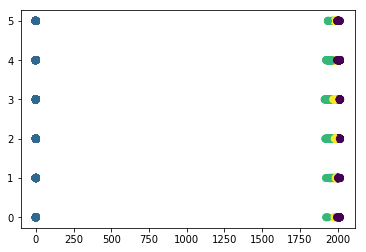

In [5]:
#-------------KMEANS nice-----------------
plt.scatter(feature_matrix[:, 0], feature_matrix[:, 1], c=y_kmeans, s=50, cmap='viridis')

#### DBSCAN
DBScan clusters based on density. Density is measured through distance between points. Unlike K-means, this algorithm determines the number of clusters. 

Similar to Kmeans, the data is not set well concerning the text as the values are binary. Movies in year 0 seem to be one large cluster while the other documented years create 2 clusters. 

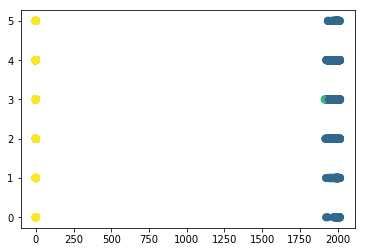

In [6]:
plt.scatter(feature_matrix[:, 0], feature_matrix[:, 1], c=y_DBclustering, s=50, cmap='viridis')

## Conclusion
Based on the data setup, it is difficult to understand the results. Genres and tags are split into multiple columns and contain binary data for each instance. With the variety of columns, plotting is difficult to understand. In terms of algorithms, Kmeans is set to four clusters based on DBScan's output of 3 clusters. All in all, altering the input data will assist with better understandable output.


## References


https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
    
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html

https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data